In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('classic')
from numpy_ext import rolling_apply
from scipy import stats
from arch.univariate import EWMAVariance
from arch import arch_model

In [2]:
def get_q2_data():
    df =pd.read_csv('./data/QRM-2022-cw1-data-b.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['DOG'].pct_change())
    df['loss'] = -1*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    return df.set_index('Date')


In [4]:
def es(loss: np.ndarray, var: np.ndarray):
    # check if loss[0 to n inclusive] > var[n+1]
    loss = loss[:-1]
    breach_mask = loss>var[-1]
    if not breach_mask.sum():
        return None
    return loss[breach_mask].sum() / breach_mask.sum()

def es_n(loss: np.ndarray, var: float):
    # check if loss[0 to n inclusive] > var
    breach_mask = loss>var
    if not breach_mask.sum():
        return None
    return loss[breach_mask].sum() / breach_mask.sum()

def print_viols_and_plot(data):
    data[['max_loss','var_95','var_99','es_95','es_99']].plot(style=['r','k--','b--','k-','b-'], lw=0.8); plt.show()

    num_days = (~data['var_95'].isna()).sum()
    viols_95 = (data['loss']>data['var_95']).sum()
    viols_99 = (data['loss']>data['var_99']).sum()

    print(f"violations 95%: {viols_95}, {100*viols_95/num_days:.2f}%")
    print(f"violations 99%: {viols_99}, {100*viols_99/num_days:.2f}%")

In [5]:
def garch_var(x, alpha):
    
    model = arch_model(x.dropna(),
                    mean='zero', 
                    vol='GARCH', 
                    p=1, q=1, rescale=False, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid.values, alpha)
    std = np.sqrt(var)
    var = q*std
    return var

def garch_es(x, alpha):
        
    model = arch_model(x.dropna(),
                    mean='zero', 
                    vol='GARCH', 
                    p=1, q=1, rescale=False, dist='normal')

    model_fit = model.fit(update_freq=-1, disp=0)
    forecasts = model_fit.forecast(reindex=False)
    var = forecasts.variance.iloc[0,0]
    q = np.quantile(model_fit.std_resid, alpha)
    res_exp_sh = es_n(model_fit.std_resid, q)
    
    exp_sh = (var**0.5)*res_exp_sh
    return exp_sh

# Q2 a)

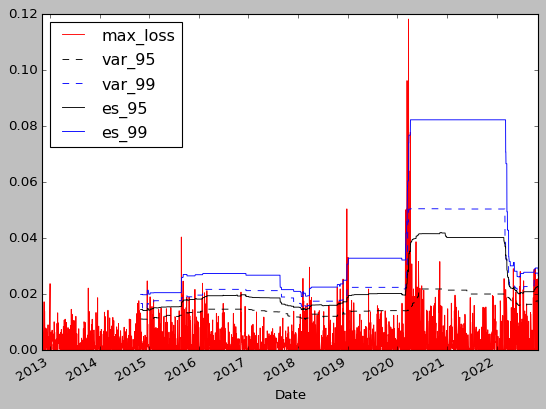

violations 95%: 119, 5.90%
violations 99%: 37, 1.83%


In [6]:
df = get_q2_data()

df['var_95'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.95)).shift(1)
df['var_99'] = df['loss'].rolling(500).apply(lambda x: np.quantile(x, 0.99)).shift(1)

df['es_95'] = rolling_apply(es, 501, df['loss'].values, df['var_95'].values)
df['es_99'] = rolling_apply(es, 501, df['loss'].values, df['var_99'].values)
df_a = df.copy()

print_viols_and_plot(df_a)

# Q2 b)

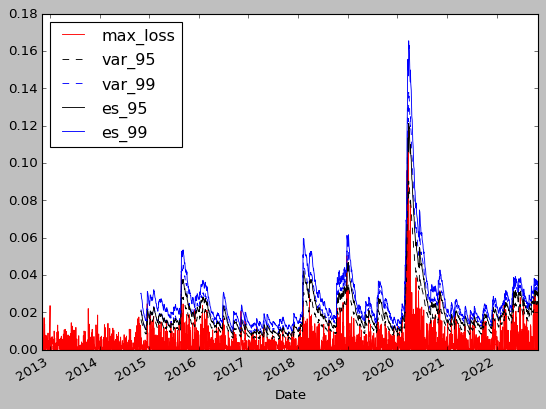

violations 95%: 102, 5.05%
violations 99%: 24, 1.19%


In [7]:
df = get_q2_data()

df['std_forc'] = 0

alpha = 0.06
for i in range(2, len(df)):
    df.iloc[i, 4] = np.sqrt(alpha*(df.iloc[i-1,2]**2) + (1-alpha)*(df.iloc[i-1,4]**2))


df['z_t'] = df['loss']/df['std_forc']
df.replace([np.inf, -np.inf], 0, inplace=True)

# shift 1 as quartile needs the n previous
df['q_95'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.95)).shift(1)
df['q_99'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.99)).shift(1)

df['es_95_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_95'].values)
df['es_99_z_t'] = rolling_apply(es, 501, df['z_t'].values, df['q_99'].values)



df['var_95'] = df['q_95']*df['std_forc']
df['var_99'] = df['q_99']*df['std_forc']
df['es_95'] = df['std_forc']*df['es_95_z_t']
df['es_99'] = df['std_forc']*df['es_99_z_t']

df_b = df.copy()
print_viols_and_plot(df_b)

# Q2 c)

In [19]:
df = get_q2_data()

df['var_95']= df['loss'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.95)).shift(1)
df['es_95']= df['loss'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.95)).shift(1)

df['var_99']= df['loss'].rolling(500).apply(garch_var, kwargs=dict(alpha=0.99)).shift(1)
df['es_99']= df['loss'].rolling(500).apply(garch_es, kwargs=dict(alpha=0.99)).shift(1)

df_c = df.copy()
# takes ~3m

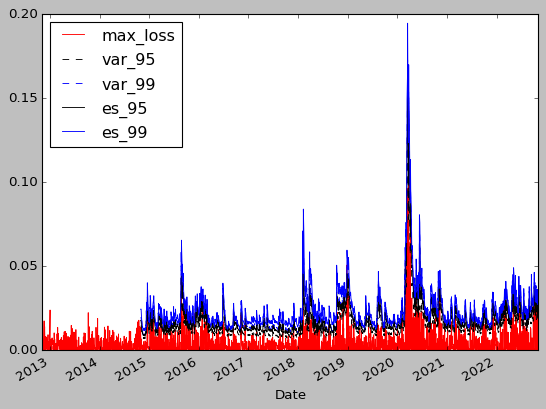

violations 95%: 110, 5.45%
violations 99%: 29, 1.44%


In [68]:


print_viols_and_plot(df_c)

# Backtesting

In [29]:
def log_lik(p: float, obs: pd.Series):

    return obs.apply(lambda x: np.log(((1-p)**(1-x))*(p**x))).sum()

def lr_uc(alpha: float, exceeds: pd.Series):
    obs = exceeds.astype(bool)
    pi_hat = np.mean(exceeds.astype(bool))
    # print(f"1-alpha: {1-alpha:.2f}. p_hat = {pi_hat=:.3f}")
    return 2*(log_lik(pi_hat, obs) - log_lik(1-alpha, obs))

def p_chi2(x, dof=1):
    return 1-stats.chi2.cdf(x, dof)

str_ci = lambda x: str(x).split('.')[1]

def get_stats(data): 
    for alpha in [0.95, 0.99]:

        str_alpha = str_ci(alpha)
        non_na_data = data[~data[f'var_{str_alpha}'].isna()]

        num_days = len(non_na_data)
        # print(f"{num_days=}")
        viol_mask = (non_na_data['loss']>non_na_data[f'var_{str_alpha}']).astype(int)
        num_viols = viol_mask.sum()

        expected_viols = (1-alpha)*num_days

        likelihood = lr_uc(alpha, viol_mask)
        p_val = p_chi2(likelihood)

        accept = f"{'Accept' if p_val>(1-alpha) else 'Reject'}"
        print(f"{alpha=}. Violations (exp): {num_viols} ({expected_viols:.2f}). Likelehood = {likelihood:.3f}. p-val: {p_val:.3f}. {accept}")                

In [31]:
print("Historical Simulation")
get_stats(df_a)
print('\nHistorical Simulation" (EWMA)')
get_stats(df_b)
print('\nFHS with Garch')
get_stats(df_c)

Historical Simulation
alpha=0.95. Violations (exp): 119 (100.90). Likelehood = 3.240. p-val: 0.072. Accept
alpha=0.99. Violations (exp): 37 (20.18). Likelehood = 11.363. p-val: 0.001. Reject

Historical Simulation" (EWMA)
alpha=0.95. Violations (exp): 102 (100.90). Likelehood = 0.013. p-val: 0.911. Accept
alpha=0.99. Violations (exp): 24 (20.18). Likelehood = 0.689. p-val: 0.407. Accept

FHS with Garch
alpha=0.95. Violations (exp): 110 (100.90). Likelehood = 0.840. p-val: 0.359. Accept
alpha=0.99. Violations (exp): 29 (20.18). Likelehood = 3.430. p-val: 0.064. Accept
